In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Sequence
from scipy.optimize import least_squares
import ehtim as eh
RADPERUAS = eh.RADPERUAS
RADPERMAS = RADPERUAS * 1e3  # rad / mas


Welcome to eht-imaging! v 1.2.10 



In [ ]:
uvfits_path = "/home/pato/Descargas/MSc/obs/1253-055.u.2020_11_02.uvf"
# eht obsdata
obs = eh.obsdata.load_uvfits(uvfits_path)

u = obs.data['u']          # lambda
v = obs.data['v']          # lambda
vis = obs.data['vis']      # complex
sigma = obs.data['sigma']  # Jy


Loading uvfits:  /home/pato/Descargas/MSc/obs/1253-055.u.2020_11_02.uvf
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Warning! ignoring nonzero header PZERO values for DATE. Check your observation mjd/times!
No NX table in uvfits!


## Model: gaussian components

`p = [F0, x0, y0, fwhm0,  F1, x1, y1, fwhm1, ...]`

`0` is the **core**.


In [3]:
def gaussian_vis_circ(u_lam, v_lam, F_jy, x_mas, y_mas, fwhm_mas):
    'u,v en lambda; x,y,fwhm en mas; F en Jy'
    x = x_mas * RADPERMAS
    y = y_mas * RADPERMAS

    # FWHM -> sigma (rad) en image plane (i think)
    sigma = (fwhm_mas * RADPERMAS) / (2.0 * np.sqrt(2.0 * np.log(2.0))) #from Alejanro script

    rho2 = u_lam*u_lam + v_lam*v_lam
    gauss_factor = np.exp(-2.0 * (np.pi**2) * (sigma**2) * rho2)

    phase = np.exp(-2j * np.pi * (u_lam*x + v_lam*y))
    return F_jy * gauss_factor * phase


def model_vis(p, n_comp, u, v):
    'Suma de (n_comp+1) gaussianas (core + n_comp).'
    V = np.zeros_like(u, dtype=complex)
    for k in range(n_comp + 1):
        F, x, y, fwhm = p[4*k:4*k+4]
        V += gaussian_vis_circ(u, v, F, x, y, fwhm)
    return V


In [4]:
def residuals_complex(p, n_comp, u, v, vis_obs, sigma):
    Vmod = model_vis(p, n_comp, u, v)
    r = (vis_obs - Vmod) / sigma
    return np.hstack([r.real, r.imag])


def chisq(p, n_comp, u, v, vis_obs, sigma):
    r = residuals_complex(p, n_comp, u, v, vis_obs, sigma)
    return float(np.sum(r*r))


## Seeds & bounds 

- if `bounds=None` -> no bounds.
- if `bounds=(lb, ub)` -> se usan.


In [7]:
@dataclass
class CompSeed:
    F_jy: float
    x_mas: float
    y_mas: float
    fwhm_mas: float


def pack_params(seeds: Sequence[CompSeed]):
    p = []
    for s in seeds:
        p += [s.F_jy, s.x_mas, s.y_mas, s.fwhm_mas]
    return np.array(p, dtype=float)


def make_default_bounds(n_comp, flux_min=0.0, fwhm_min_mas=0.0, pos_absmax_mas: Optional[float] = None):
    npar = 4*(n_comp+1)
    lb = -np.inf*np.ones(npar)
    ub =  np.inf*np.ones(npar)

    for k in range(n_comp+1):
        lb[4*k + 0] = flux_min
        lb[4*k + 3] = fwhm_min_mas

    if pos_absmax_mas is not None:
        for k in range(n_comp+1):
            lb[4*k + 1] = -pos_absmax_mas
            ub[4*k + 1] =  pos_absmax_mas
            lb[4*k + 2] = -pos_absmax_mas
            ub[4*k + 2] =  pos_absmax_mas

    return lb, ub


In [9]:
n_comp = 3  # non core components(core + n_comp )

# initial guess to help the model, first one is the core.
seeds = [
    CompSeed(F_jy=8.6, x_mas=0.0, y_mas=0.0, fwhm_mas=0.06),  # core
    CompSeed(F_jy=3.7, x_mas=0.19*np.sin(-146*np.pi/180), y_mas=0.19*np.cos(-146*np.pi/180), fwhm_mas=0.09),  # comp1
    CompSeed(F_jy=1.6, x_mas=0.63*np.sin(-144*np.pi/180), y_mas=0.63*np.cos(-144*np.pi/180), fwhm_mas=0.17),
    CompSeed(F_jy=0.5, x_mas=0.97*np.sin(-139*np.pi/180), y_mas=0.97*np.cos(-139*np.pi/180), fwhm_mas=0.39)
]
p0 = pack_params(seeds)

use_bounds = True
if use_bounds:
    lb, ub = make_default_bounds(n_comp=n_comp, flux_min=0.0, fwhm_min_mas=0.0, pos_absmax_mas=2.0)
    bounds = (lb, ub)
else:
    bounds = (-np.inf, np.inf)


res = least_squares(
    residuals_complex,
    x0=p0,
    bounds=bounds,
    args=(n_comp, u, v, vis, sigma),
    method="trf"
)

p_best = res.x

print("Success?:", res.success, res.message)
print("\n best-fit (Jy, mas, mas, mas):")
for k in range(n_comp+1):
    F, x, y, fwhm = p_best[4*k:4*k+4]
    label = "core" if k == 0 else f"c{k}"
    print(f"  {label:>4s}: F={F:10.6f}  x={x:10.6f}  y={y:10.6f}  fwhm={fwhm:10.6f}")


Success?: True `ftol` termination condition is satisfied.

 best-fit (Jy, mas, mas, mas):
  core: F=  3.349319  x=  0.151658  y=  0.211151  fwhm=  0.108427
    c1: F=  9.399964  x= -0.027036  y= -0.067041  fwhm=  0.039440
    c2: F=  1.713294  x=  0.444694  y=  0.584507  fwhm=  0.272027
    c3: F=  0.990031  x=  2.000000  y=  2.000000  fwhm=  3.310993


## Plots 

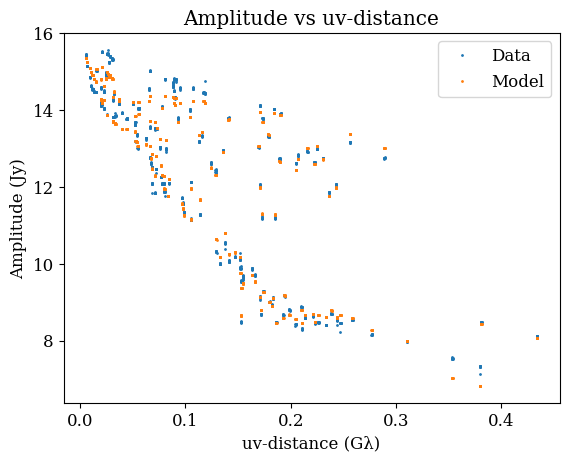

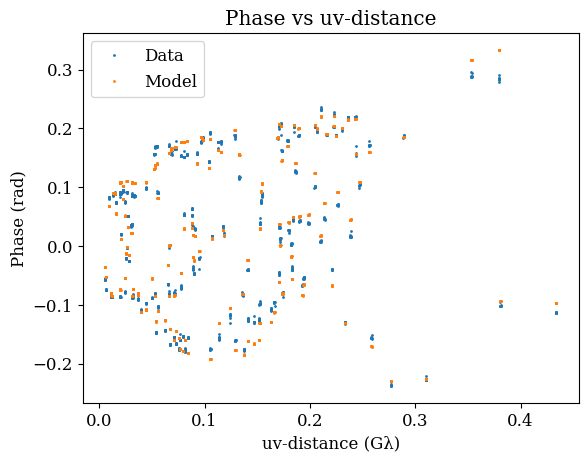

In [ ]:
def uv_distance_glambda(u_lam, v_lam):
    return np.sqrt(u_lam*u_lam + v_lam*v_lam) / 1e9


def wrap_phase(rad):
    return (rad + np.pi) % (2*np.pi) - np.pi


def difmap_style_plots(u, v, vis_obs, p_best, n_comp):
    Vmod = model_vis(p_best, n_comp, u, v)
    duv = uv_distance_glambda(u, v)

    amp_o = np.abs(vis_obs); amp_m = np.abs(Vmod)
    ph_o = wrap_phase(np.angle(vis_obs)); ph_m = wrap_phase(np.angle(Vmod))

    re_o, im_o = vis_obs.real, vis_obs.imag
    re_m, im_m = Vmod.real, Vmod.imag

    dV = vis_obs - Vmod
    amp_r = np.abs(dV)
    ph_r = wrap_phase(np.angle(dV))


    plt.figure()
    plt.plot(duv, amp_o, '.', ms=2, label='Data')
    plt.plot(duv, amp_m, '.', ms=2, label='Model')
    plt.xlabel('uv-distance (Gλ)'); plt.ylabel('Amplitude (Jy)')
    plt.title('Amplitude vs uv-distance'); plt.legend()

    plt.figure()
    plt.plot(duv, ph_o, '.', ms=2, label='Data')
    plt.plot(duv, ph_m, '.', ms=2, label='Model')
    plt.xlabel('uv-distance (Gλ)'); plt.ylabel('Phase (rad)')
    plt.title('Phase vs uv-distance'); plt.legend()
"""
    plt.figure()
    plt.plot(duv, re_o, '.', ms=2, label='Re Data')
    plt.plot(duv, re_m, '.', ms=2, label='Re Model')
    plt.xlabel('uv-distance (Gλ)'); plt.ylabel('Real(V) (Jy)')
    plt.title('Real(V) vs uv-distance'); plt.legend()
"""


difmap_style_plots(u, v, vis, p_best, n_comp)


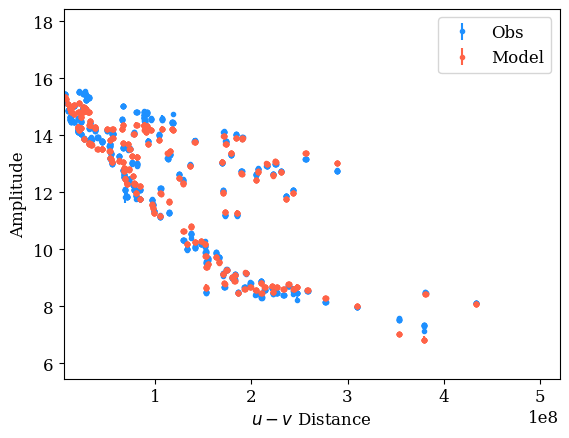

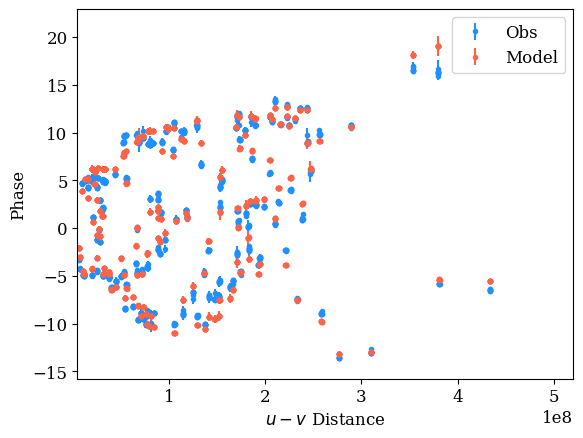

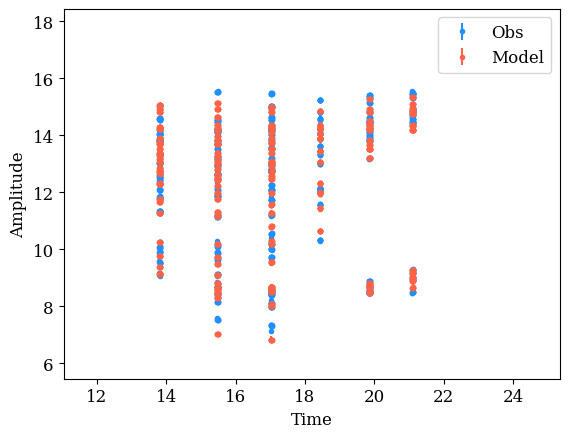

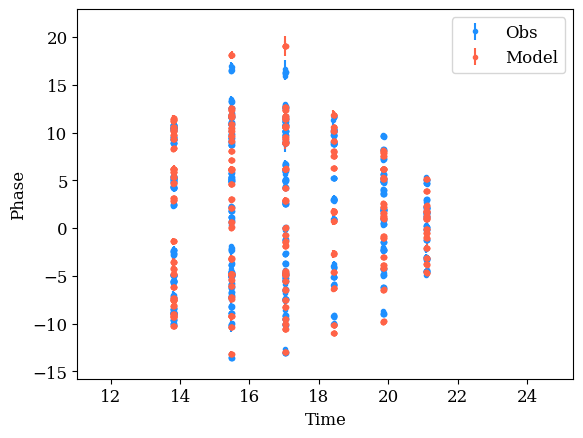

<Axes: xlabel='Time', ylabel='Phase'>

In [ ]:
vis_best = model_vis(p_best, n_comp, u, v)

obs_model = obs.copy()
obs_model.data["vis"] = vis_best

eh.plotall_obs_compare([obs, obs_model],"uvdist","amp",legendlabels=["Obs","Model"])
eh.plotall_obs_compare([obs, obs_model],"uvdist","phase",legendlabels=["Obs","Model"])
eh.plotall_obs_compare([obs, obs_model],"time","amp",legendlabels=["Obs","Model"])
eh.plotall_obs_compare([obs, obs_model],"time","phase",legendlabels=["Obs","Model"])